In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import KFold
from create_matrix import *
import os
import sys
from tensor_custom_core import *
from create_matrix import *
from tensor_custom_core import *
from degree_days import dds
from sklearn.model_selection import train_test_split, KFold
from common import compute_rmse_fraction
from common import compute_rmse

appliance_index = {appliance: APPLIANCES_ORDER.index(appliance) for appliance in APPLIANCES_ORDER}
APPLIANCES = ['fridge', 'hvac', 'wm', 'mw', 'oven', 'dw']
year = 2014
n_splits = 10
case=2
a=2
cost='abs'

In [3]:
def un_normalize(x, maximum, minimum):
    return (maximum - minimum) * x + minimum

def get_tensor(df, dfc):
    start, stop = 1, 13
    energy_cols = np.array(
        [['%s_%d' % (appliance, month) for month in range(start, stop)] for appliance in APPLIANCES_ORDER]).flatten()

    static_cols = ['area', 'total_occupants', 'num_rooms']
    static_df = df[static_cols]
    static_df = static_df.div(static_df.max())
    weather_values = np.array(dds[2014][region][start - 1:stop - 1]).reshape(-1, 1)

    dfc = df.copy()

    df = dfc[energy_cols]
    col_max = df.max().max()
    col_min = df.min().min()
    # df = (1.0 * (df - col_min)) / (col_max - col_min)
    tensor = df.values.reshape((len(df), 7, stop - start))
    M, N, O = tensor.shape
    return tensor

In [4]:
region = 'Austin'
au_df, au_dfc = create_matrix_single_region("Austin", year)
au_tensor = get_tensor(au_df, au_dfc)
static_au = au_df[['area','total_occupants','num_rooms']].copy()
static_au['area'] = static_au['area'].div(4000)
static_au['total_occupants'] = static_au['total_occupants'].div(8)
static_au['num_rooms'] = static_au['num_rooms'].div(8)
static_au = static_au.values
region = 'SanDiego'
sd_df, sd_dfc = create_matrix_single_region("SanDiego", year)
sd_tensor = get_tensor(sd_df, sd_dfc)
static_sd = sd_df[['area','total_occupants','num_rooms']].copy()
static_sd['area'] = static_sd['area'].div(4000)
static_sd['total_occupants'] = static_sd['total_occupants'].div(8)
static_sd['num_rooms'] = static_sd['num_rooms'].div(8)
static_sd = static_sd.values

In [10]:
au_df.index

Int64Index([  22,   26,   48,   59,   68,   77,   86,   93,   94,  101,
            ...
            9933, 9935, 9936, 9937, 9938, 9939, 9942, 9971, 9981, 9982],
           dtype='int64', length=533)

In [63]:
cost='l21'
a = 2
b = 3
H_au, A_au, T_au, H_aus, A_aus, T_aus, HAT_aus, cost_aus = learn_HAT_adagrad(case, au_tensor, a, b, num_iter=5000, lr=0.1, dis=False, cost_function=cost, T_known=np.ones(12).reshape(-1, 1))

In [64]:
pred = {}
out = {}

for iters in range(100, 5000, 100):
    pred[iters] = {}
    for appliance in APPLIANCES_ORDER:
        pred[iters][appliance] = []

for iters in range(100, 5000, 100):
    HAT = multiply_case(H_aus[iters], A_aus[iters], T_aus[iters], case)
    
    for appliance in APPLIANCES_ORDER[1:]:
        pred[iters][appliance].append(pd.DataFrame(HAT[:, appliance_index[appliance], :], index=au_df.index))

In [65]:
for iters in range(100, 5000, 100):
    out[iters] = {}
    for appliance in APPLIANCES_ORDER[1:]:
        s = pd.concat(pred[iters][appliance]).ix[au_df.index]
        if appliance=="hvac":
            out[iters][appliance] = compute_rmse_fraction(appliance,s[range(4, 10)],'Austin')[2]
        else:   
            out[iters][appliance] = compute_rmse_fraction(appliance, s,'Austin')[2]

/home/yj9xs/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


In [69]:
out[4900]

{'dw': 1.2736401573310483,
 'fridge': 5.8997604292348784,
 'hvac': 8.5727092650844376,
 'mw': 1.6123899801204367,
 'oven': 1.5076843599410918,
 'wm': 0.64368718856208407}

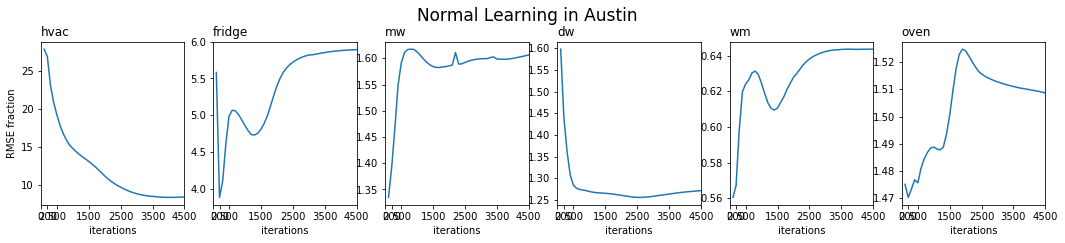

In [67]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(18, 3))
ax = axes.flatten()
count = 0

ticks = [0, 200, 500, 1500, 2500, 3500, 4500]
out_df = pd.DataFrame(out).T
for appliance in APPLIANCES_ORDER[1:]:
    df = out_df[[appliance]]
    df.plot(ax=ax[count])

    ax[count].set_xlabel("iterations");
    ax[count].set_xlim(0, 2100)
    ax[count].locator_params(tight=False, nbins=20, axis='x')
    ax[count].set_xticks(ticks)
    ax[count].legend().set_visible(False)
    
    ax[count].set_title(appliance, loc="left")
    count += 1
ax[0].set_ylabel('RMSE fraction')
plt.suptitle("Normal Learning in Austin", fontsize=17,y=1.04)

plt.savefig("./analysis/0720/RMSE of normal learning in Austin.pdf", bbox_inches="tight", dpi=300, format="pdf")